# TM10007 Assignment template -- ECG data

### Importing modules

In [197]:

! pip install sklearn numpy matplotlib imbalanced-learn statsmodels

import os
import zipfile
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels
import seaborn as sns
import warnings
import statistics
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score

from sklearn.compose import TransformedTargetRegressor
from scipy.stats import shapiro, lognorm, randint
from scipy.spatial.distance import cdist
from sklearn.model_selection import StratifiedShuffleSplit, learning_curve, GridSearchCV, StratifiedKFold, cross_val_score, KFold, train_test_split, RandomizedSearchCV, validation_curve #, multipletests
from sklearn.preprocessing import RobustScaler, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn import datasets as ds, model_selection, metrics, neighbors
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from statsmodels.stats.multitest import multipletests
from sklearn.exceptions import ConvergenceWarning

# Classifiers
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB


## Preprocessing

### Importing our data

In [198]:
cwd = os.getcwd() # This fn will return the Current Working Directory

zip_path = os.path.join(cwd, 'ecg', 'ecg_data.zip')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(cwd, 'ecg'))

data_path = os.path.join(cwd, 'ecg', 'ecg_data.csv')
data = pd.read_csv(data_path, index_col=0)

### Exploring our data

In [199]:
# split labels from data
X = data.loc[:, data.columns != 'label']  #alles behalve label
y = data['label']  # labels

# X = X.iloc[:50, :2000]
# y = y.iloc[:50]

print(X.shape)
print(y.shape)

# normal / abnormal ECGs
total_abnormal_ECG = np.count_nonzero(y) 
total_normal_ECG = y.size -np.count_nonzero(y) 
percentage_abnormal = total_abnormal_ECG / (total_abnormal_ECG + total_normal_ECG)*100

print(f'{total_abnormal_ECG} people have an abnormal ECG')
print(f'{total_normal_ECG} people have a normal ECG')
print(f'The percentage of abnormal ECGs in this dataset is {percentage_abnormal} %')

(50, 2000)
(50,)
9 people have an abnormal ECG
41 people have a normal ECG
The percentage of abnormal ECGs in this dataset is 18.0 %


### Missing data
- Removing features if there is lot of data missing (replace all for a value)
- Removing samples (in this case patients) if there is a lot of data missing
- Imputation for generating data to fill us missing values -> median

In [200]:
def missing_data(X_design):
    # Missing data
    X_design = X_design.replace(0, np.nan)  # make all zeros to NaN
    nan_count = X_design.isna().sum().sum()  # count missing data -> 10500 in our dataset

    # Delete missing data when > --% of feature of sample is missing
    X_design = X_design.dropna(axis='columns', how='all') # deletes a feature if all values of a column (so feature) are empty
    X_design = X_design.dropna(axis='rows', how='all') # deletes a patient if all values of a row (so sample) are empty

    # Missing data to median per feature
    for column in X_design.columns:
        X_design[column].fillna(X_design[column].median(), inplace=True)
    return X_design

### Outliers
- Detect outliers using Z-score since data is not nornally distributed
- Replace outliers by the median of that feature
- Print -> check wether the outliers are changed

In [201]:
def removing_outliers(X_design):
    # supress performance warning
    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

    # Outliers: Tukey's fence 
    k=3
    fences=pd.DataFrame()
    outliers = pd.DataFrame(False, index=X_design.index, columns=X_design.columns) # create an empty DataFrame for outliers

    for col in X_design.columns:
        q1, q3 = np.percentile(X_design[col], [25, 75])
        iqr = q3 - q1
        lower_fence = q1 - k*iqr
        upper_fence = q3 + k*iqr
        fences[col]=[lower_fence, upper_fence]
        for row in X_design.index:
            if X_design.loc[row, col] < lower_fence or X_design.loc[row, col] > upper_fence:
                outliers.loc[row, col] = True # mark the place as an outlier

    row_count = (outliers == True).sum(axis=1)
    col_count = (outliers == True).sum(axis=0)
    total_count = row_count.sum() + col_count.sum()
    print(f'The total number of outliers in dataset x is {total_count}')

    # create a copy of x to modify
    new_x = X_design.copy()

    #replace outliers with maximum or minimun interquartile range of x by column
    for col in outliers.columns:
        q3 = X_design.loc[outliers[col] == False, col].quantile(0.75) # 3rd quartile of column where outlier is False
        q1 = X_design.loc[outliers[col] == False, col].quantile(0.25) # 1st quartile of column where outlier is False
        iqr = q3 - q1 # interquartile range of column where outlier is False
        lower_fence = q1 - k*iqr
        upper_fence = q3 + k*iqr
        new_x.loc[outliers[col] & (new_x[col] > upper_fence), col] = upper_fence # replace outliers with upper fence
        new_x.loc[outliers[col] & (new_x[col] < lower_fence), col] = lower_fence # replace outliers with lower fence

        X_design = new_x.copy()
    return X_design

### PIPELINE 1
- RobustScaler --> PCA + univariate --> Gaussian Naive Bayes

In [202]:
# # Confusion matrix
# cm_all = None

# for i in range(len(y_pred_1_all)):

#     cm_i = confusion_matrix(y_test_1_all[i], y_pred_1_all[i])

#     if cm_all is None:
#         cm_all = cm_i
#     else:
#         cm_all += cm_i

# # Plot the confusion matrix as a heatmap
# sns.heatmap(cm_all, annot=True, cmap='Blues')
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('Confusion matrix Pipeline 1')
# plt.show()

In [203]:
# # Loop over rows and compute ROC curve and AUC for each row
# for i in range(len(y_pred_1_all)):
#     precision, recall, thresholds = precision_recall_curve(y_test_1_all[i], y_pred_1_all[i])
#     auc = average_precision_score(y_test_1_all[i], y_pred_1_all[i])

#     # Plot the ROC curve for each row
#     plt.plot(recall, precision, lw=2, label='PR curve it. %d (AP = %0.2f)' % (i+1, auc))

# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-recall curve for all rows')
# plt.legend(loc="lower right", fontsize=8)
# plt.show()


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


The total number of outliers in dataset x is 3886
The total number of outliers in dataset x is 1012
shape after balancing (72, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1_before = best_hp_1_before.append(rand_search_1a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
shape of X_design after pca (72, 3)
size of features selected(1,)
after feature selection: (72, 1)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:109: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)


The total number of outliers in dataset x is 3694
The total number of outliers in dataset x is 874
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1_before = best_hp_1_before.append(rand_search_1a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
shape of X_design after pca (74, 2)
size of features selected(1,)
after feature selection: (74, 1)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:109: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)


The total number of outliers in dataset x is 3812
The total number of outliers in dataset x is 734
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1_before = best_hp_1_before.append(rand_search_1a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
shape of X_design after pca (74, 2)
size of features selected(1,)
after feature selection: (74, 1)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:109: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)


The total number of outliers in dataset x is 3198
The total number of outliers in dataset x is 900
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1_before = best_hp_1_before.append(rand_search_1a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
shape of X_design after pca (74, 3)
size of features selected(1,)
after feature selection: (74, 1)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:109: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)


The total number of outliers in dataset x is 3038
The total number of outliers in dataset x is 1502
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1_before = best_hp_1_before.append(rand_search_1a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
4                0.5
shape of X_design after pca (74, 3)
size of features selected(2,)
after feature selection: (74, 2)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:109: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)


The total number of outliers in dataset x is 4040
The total number of outliers in dataset x is 650
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1_before = best_hp_1_before.append(rand_search_1a.best_params_,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:109: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykerne

   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
4                0.5
5                0.5
shape of X_design after pca (74, 2)
size of features selected(1,)
after feature selection: (74, 1)
The total number of outliers in dataset x is 3454
The total number of outliers in dataset x is 1230
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1_before = best_hp_1_before.append(rand_search_1a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
4                0.5
5                0.5
6                0.5
shape of X_design after pca (74, 2)
size of features selected(1,)
after feature selection: (74, 1)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:109: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)


The total number of outliers in dataset x is 3660
The total number of outliers in dataset x is 752
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1_before = best_hp_1_before.append(rand_search_1a.best_params_,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:109: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
4                0.5
5                0.5
6                0.5
7                0.5
shape of X_design after pca (74, 2)
size of features selected(1,)
after feature selection: (74, 1)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)


The total number of outliers in dataset x is 3216
The total number of outliers in dataset x is 916
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1_before = best_hp_1_before.append(rand_search_1a.best_params_,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:109: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
4                0.5
5                0.5
6                0.5
7                0.5
8                0.5
shape of X_design after pca (74, 3)
size of features selected(3,)
after feature selection: (74, 3)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)


The total number of outliers in dataset x is 4186
The total number of outliers in dataset x is 568
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1_before = best_hp_1_before.append(rand_search_1a.best_params_,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3436546786.py:109: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykerne

   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
4                0.5
5                0.5
6                0.5
7                0.5
8                0.5
9                0.5
shape of X_design after pca (74, 2)
size of features selected(1,)
after feature selection: (74, 1)
Mean and std of F1 scores of pipeline 1: 0.21666666666666667 +/- 0.3689323936863109
The optimal hyperparameters per split:    clf__var_smoothing
0        5.336699e-08
1        1.232847e-03
2        2.310130e-01
3        1.000000e-07
4        5.336699e-02
5        6.579332e-03
6        8.111308e-03
7        2.310130e-04
8        8.111308e-02
9        1.873817e-05
The best pipes per split [Pipeline(steps=[('clf', GaussianNB(var_smoothing=5.336699231206302e-08))]), Pipeline(steps=[('clf', GaussianNB(var_smoothing=0.0012328467394420659))]), Pipeline(steps=[('clf', GaussianNB(var_smoothing=0.23101297000831597))]), Pipeline(steps=[('clf', GaussianNB(var_smoothing=1e-0

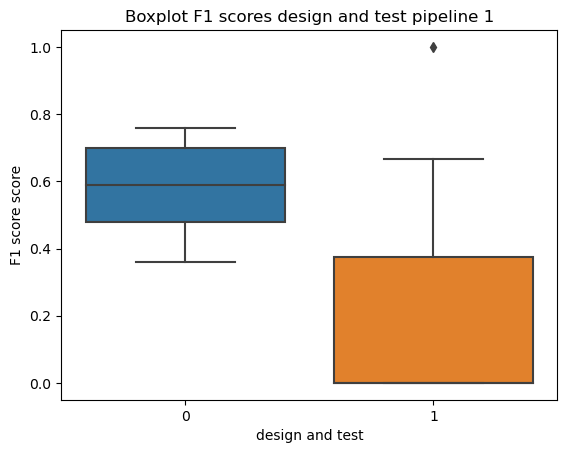

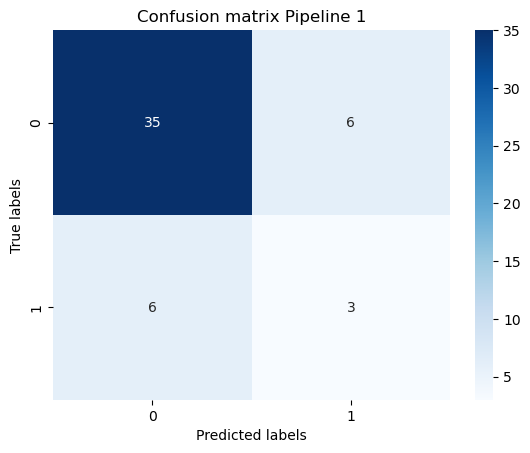

c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


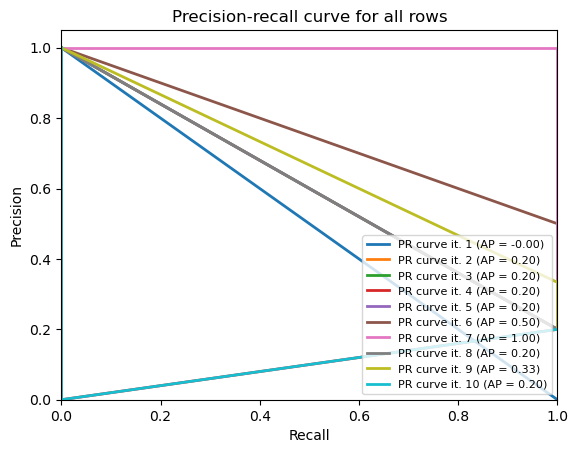

              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.50      0.50      0.50         2
           2       0.50      0.33      0.40         3
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         0

   micro avg       0.33      0.33      0.33         9
   macro avg       0.27      0.37      0.28         9
weighted avg       0.31      0.33      0.30         9
 samples avg       0.18      0.30      0.22         9



c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [204]:
# PIPELINE 1
# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) 

f1_design_1_before = []
f1_test_1_before = []

f1_design_1_after = []
f1_test_1_after = []

results_1 = pd.DataFrame()
best_pipe_1 = []
best_hp_1_before = pd.DataFrame()
best_hp_1 = pd.DataFrame()

y_test_1_all = []
y_pred_1_all = []

for design_index, test_index in outer_cv.split(X, y): 
    X_design = X.transpose()[design_index]
    X_design = X_design.transpose()
    # print(f'Size_X_design {X_design.shape}') # print size of X_design
    y_design = y[design_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_1 = y[test_index].tolist()
    y_test_1_all.append(y_test_1)
    # print(y_test_1_all)
    # print(f'Size X_test {X_test.shape}')     # print size of X_test
    
    # correct for missing data
    # X_design = missing_data(X_design)
    # X_test = missing_data(X_test)
    # remove outliers
    X_design = removing_outliers(X_design)
    X_test = removing_outliers(X_test)

    # balance the classes, so design set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_design, y_design)
    X_design = X_resampled
    y_design = y_resampled   

    print(f'shape after balancing {X_design.shape}')

    ## PIPELINE 1: RobustScaler --> PCA + univariate --> Gaussian Naive Bayes
    
    # Define pipeline 1
    pipeline_1a = Pipeline([
        ('scaler', RobustScaler()),
        ('var_threshold', VarianceThreshold(threshold=0.0)),
        ('pca', PCA(n_components=0.5)),
    ])

    param_grid_1a = {
        'pca__n_components': [0.5],#,0.75, 0.9, 0.95, 0.99],
        }

    # Perform grid search with inner cross-validation, part 1
    rand_search_1a = RandomizedSearchCV(pipeline_1a, param_distributions=param_grid_1a, n_iter=10, cv=inner_cv, scoring='f1', n_jobs=-1) #klopt n__iter
    rand_search_1a.fit(X_design, y_design) # klopt dit fit_transform?
    X_design = rand_search_1a.best_estimator_.transform(X_design)
    X_test = rand_search_1a.best_estimator_.transform(X_test)
    
    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_1_before = best_hp_1_before.append(rand_search_1a.best_params_,ignore_index=True)
    print(best_hp_1_before)
    print(f'shape of X_design after pca {X_design.shape}')

    sel_kb = SelectKBest(f_classif, k='all')
    sel_kb.fit(X_design, y_design)
    p_values = sel_kb.pvalues_

    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values, alpha=0.05, method='fdr_bh')
    features_selected=np.array(np.where(reject_fdr)[0])
    print(f'size of features selected{features_selected.shape}')
    X_design = X_design[:,features_selected]
    X_test = X_test[:,features_selected]
    
    # pipeline 1b
    pipeline_1b = Pipeline([
        ('clf', GaussianNB())
    ])

    # Define scores BEFORE hyperparameter tuning
    pipeline_1b.fit(X_design, y_design)
 
    y_pred_design_1 = pipeline_1b.predict(X_design)
    f1_design_1_bef = f1_score(y_design, y_pred_design_1)
    f1_design_1_before.append(f1_design_1_bef)

    y_pred_test_1_before = pipeline_1b.predict(X_test)
    f1_test_1_bef = f1_score(y_test_1, y_pred_test_1_before)
    f1_test_1_before.append(f1_test_1_bef)

    # Define hyperparameters of pipeline 1
    param_grid_1b = {
    'clf__var_smoothing': np.logspace(0,-9, num=100),
    }

    print(f'after feature selection: {X_design.shape}')

    # Perform grid search with inner cross-validation, part 2
    model_1 = RandomizedSearchCV(pipeline_1b, param_distributions=param_grid_1b, n_iter=50, cv=inner_cv, scoring='f1', n_jobs=-1) #klopt n__iter
    model_1.fit(X_design, y_design)
    results = pd.DataFrame(model_1.cv_results_)
    results_1 = results_1.append(results,ignore_index=True)

    # Define scores AFTER hyperparameter tuning 
    y_pred_design_1_after = model_1.predict(X_design)
    f1_design_1_aft = f1_score(y_design, y_pred_design_1_after)
    f1_design_1_after.append(f1_design_1_aft)
    
    y_pred_test_1_after = model_1.predict(X_test)
    y_pred_1_all.append(y_pred_test_1_after)
    
    f1_test_1_aft = f1_score(y_test_1, y_pred_test_1_after)
    f1_test_1_after.append(f1_test_1_aft)

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)
    # Stores the optimum model in best_pipe
    best_pipe_1.append(model_1.best_estimator_)

# Save results of inner CV into .csv file
results_1.to_csv('results_1.csv', index=False)

print(f'Mean and std of F1 scores of pipeline 1: {statistics.mean(f1_test_1_after)} +/- {statistics.stdev(f1_test_1_after)}')

print(f'The optimal hyperparameters per split: {best_hp_1}')
print(f'The best pipes per split {best_pipe_1}')

print(f'The design F1 scores before tuning {f1_design_1_before}')
print(f'The test F1 scores before tuning {f1_test_1_before}')

print(f'The design F1 scores after tuning {f1_design_1_after}')
print(f'The test F1 scores afer tuning {f1_test_1_after}')


data_1 = [f1_design_1_after, f1_test_1_after]
sns.boxplot(data=data_1)
plt.title('Boxplot F1 scores design and test pipeline 1')
plt.xlabel('design and test')
plt.ylabel('F1 score score')
plt.show()

# Loop over rows and compute precision recall curve for each row
for i in range(len(y_pred_1_all)):
    precision, recall, thresholds = precision_recall_curve(y_test_1_all[i], y_pred_1_all[i])
    auc = average_precision_score(y_test_1_all[i], y_pred_1_all[i])

    # Plot the ROC curve for each row
    plt.plot(recall, precision, lw=2, label='PR curve it. %d (AP = %0.2f)' % (i+1, auc))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve for all rows')
plt.legend(loc="lower right", fontsize=8)
plt.show()

# from sklearn.metrics import classification_report
# print(classification_report(y_test_1_all, y_pred_1_all))



### PIPELINE 2
- PCA-Uni --> Quadratic Discriminant Analysis

In [205]:
cwd = os.getcwd() # This fn will return the Current Working Directory

zip_path = os.path.join(cwd, 'ecg', 'ecg_data.zip')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(cwd, 'ecg'))

data_path = os.path.join(cwd, 'ecg', 'ecg_data.csv')
data = pd.read_csv(data_path, index_col=0)

# split labels from data
X = data.loc[:, data.columns != 'label']  #alles behalve label
y = data['label']  # labels

# X = X.iloc[:50, :2000]
# y = y.iloc[:50]

c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3886
The total number of outliers in dataset x is 1012
shape after balancing (72, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3320627061.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_2_before = best_hp_2_before.append(rand_search_2a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
shape of X_design after pca (72, 2)
size of features selected(1,)
Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3694
The total number of outliers in dataset x is 874
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3320627061.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_2_before = best_hp_2_before.append(rand_search_2a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
shape of X_design after pca (74, 2)
size of features selected(2,)
Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3812
The total number of outliers in dataset x is 734
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3320627061.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_2_before = best_hp_2_before.append(rand_search_2a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
shape of X_design after pca (74, 2)
size of features selected(1,)
Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3198
The total number of outliers in dataset x is 900
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3320627061.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_2_before = best_hp_2_before.append(rand_search_2a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
shape of X_design after pca (74, 2)
size of features selected(1,)
Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3038
The total number of outliers in dataset x is 1502
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3320627061.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_2_before = best_hp_2_before.append(rand_search_2a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
4                0.5
shape of X_design after pca (74, 3)
size of features selected(1,)
Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 4040
The total number of outliers in dataset x is 650
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3320627061.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_2_before = best_hp_2_before.append(rand_search_2a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
4                0.5
5                0.5
shape of X_design after pca (74, 2)
size of features selected(2,)
Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3454
The total number of outliers in dataset x is 1230
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3320627061.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_2_before = best_hp_2_before.append(rand_search_2a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
4                0.5
5                0.5
6                0.5
shape of X_design after pca (74, 3)
size of features selected(1,)
Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3660
The total number of outliers in dataset x is 752
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3320627061.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_2_before = best_hp_2_before.append(rand_search_2a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
4                0.5
5                0.5
6                0.5
7                0.5
shape of X_design after pca (74, 2)
size of features selected(2,)
Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3216
The total number of outliers in dataset x is 916
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3320627061.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_2_before = best_hp_2_before.append(rand_search_2a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
4                0.5
5                0.5
6                0.5
7                0.5
8                0.5
shape of X_design after pca (74, 3)
size of features selected(3,)
Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 4186
The total number of outliers in dataset x is 568
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
4                0.5
5                0.5
6                0.5
7                0.5
8                0.5
9                0.5
shape of X_design after pca (74, 2)
size of features selected(1,)
Mean and std of F1 scores of pipeline 1: 0.25 +/- 0.42491829279939874
The optimal hyperparameters per split: Empty DataFrame
Columns: []
Index: []
The best pipes per split []
The design F1 scores before tuning []
The test F1 scores before tuning []
The design F1 scores after tuning [0.5185185185185185, 0.7575757575757576, 0.6229508196721311, 0.6875, 0.5, 0.6774193548387097, 0.6349206349206349, 0.5, 0.7761194029850748, 0.7187499999999999]
The test F1 scores afer tuning [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.5, 0.0]


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3320627061.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_2_before = best_hp_2_before.append(rand_search_2a.best_params_,ignore_index=True)


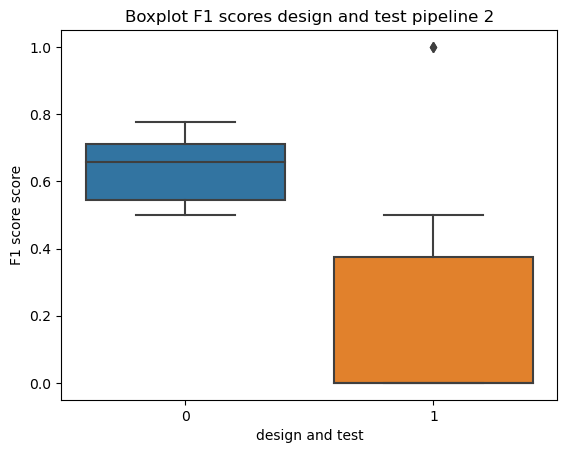

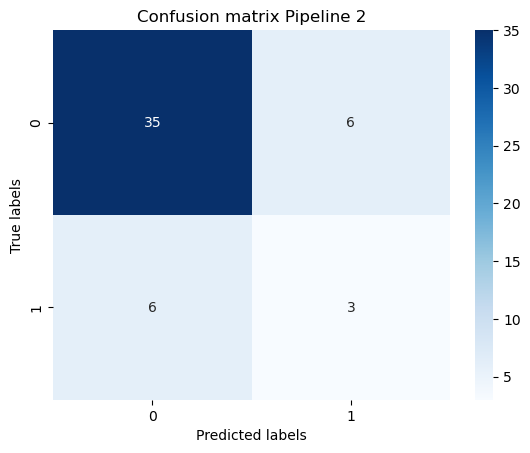

c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


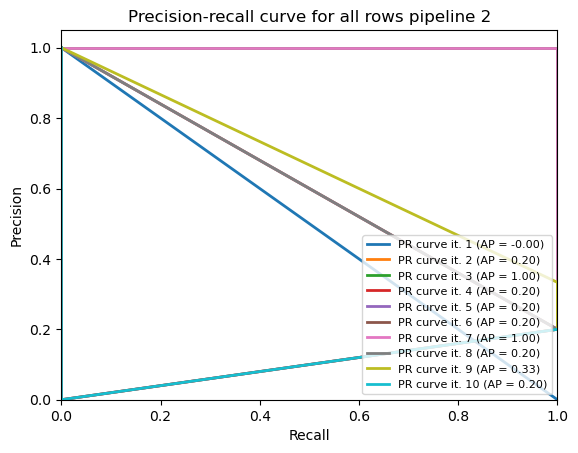

              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.00      0.00      0.00         2
           2       0.50      0.33      0.40         3
           3       0.50      0.33      0.40         3
           4       0.00      0.00      0.00         0

   micro avg       0.33      0.33      0.33         9
   macro avg       0.27      0.33      0.26         9
weighted avg       0.37      0.33      0.32         9
 samples avg       0.23      0.30      0.25         9



c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [206]:
# PIPELINE 2
# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

f1_design_2_before = []
f1_test_2_before = []

f1_design_2_after = []
f1_test_2_after = []

results_2 = pd.DataFrame()
best_pipe_2 = []
best_hp_2_before = pd.DataFrame()
best_hp_2 = pd.DataFrame()


y_test_2_all = []
y_pred_2_all = []

for design_index, test_index in outer_cv.split(X, y): 
    X_design = X.transpose()[design_index]
    X_design = X_design.transpose()
    print(f'Size_X_design {X_design.shape}') # print size of X_design
    y_design = y[design_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_2 = y[test_index].tolist()
    y_test_2_all.append(y_test_2)
    print(f'Size X_test {X_test.shape}')     # print size of X_test
    
    # correct for missing data
    # X_design = missing_data(X_design)
    # X_test = missing_data(X_test)
    # remove outliers
    X_design = removing_outliers(X_design)
    X_test = removing_outliers(X_test)

    # balance the classes, so design set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_design, y_design)
    X_design = X_resampled
    y_design = y_resampled   

    print(f'shape after balancing {X_design.shape}')

    ## PIPELINE 2: QDA
    
    # Define pipeline 2
    pipeline_2a = Pipeline([
        ('scaler', RobustScaler()),
        ('var_threshold', VarianceThreshold(threshold=0.0)),
        ('pca', PCA(n_components=0.5)),
    ])

    param_grid_2a = {
        'pca__n_components': [0.5],#0.75, 0.9, 0.95, 0.99],
        }

    # Perform grid search with inner cross-validation, part 1
    rand_search_2a = RandomizedSearchCV(pipeline_2a, param_distributions=param_grid_2a, n_iter=10, cv=inner_cv, scoring='f1', n_jobs=-1) #klopt n__iter
    rand_search_2a.fit(X_design, y_design) # klopt dit fit_transform?
    X_design = rand_search_2a.best_estimator_.transform(X_design)
    X_test = rand_search_2a.best_estimator_.transform(X_test)
    
    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_2_before = best_hp_2_before.append(rand_search_2a.best_params_,ignore_index=True)
    print(best_hp_2_before)
    print(f'shape of X_design after pca {X_design.shape}')

    sel_kb = SelectKBest(f_classif, k='all')
    sel_kb.fit(X_design, y_design)
    p_values = sel_kb.pvalues_

    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values, alpha=0.05, method='fdr_bh')
    features_selected=np.array(np.where(reject_fdr)[0])
    print(f'size of features selected{features_selected.shape}')
    X_design = X_design[:,features_selected]
    X_test = X_test[:,features_selected]

    # design the classifier on the selected features with the best hyperparameters to create best designed classifier
    model_2 = QuadraticDiscriminantAnalysis()
    model_2.fit(X_design, y_design)
    # results = pd.DataFrame(model_2.cv_results_)
    # results_2 = results_2.append(results,ignore_index=True)


    # Define scores AFTER hyperparameter tuning 
    y_pred_design_2_after = model_2.predict(X_design)
    f1_design_2_aft = f1_score(y_design, y_pred_design_2_after)
    f1_design_2_after.append(f1_design_2_aft)
   
    y_pred_test_2_after = model_2.predict(X_test)
    y_pred_2_all.append(y_pred_test_2_after)
   
    f1_test_2_aft = f1_score(y_test_2, y_pred_test_2_after)
    f1_test_2_after.append(f1_test_2_aft)

    # # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    # best_hp_2 = best_hp_2.append(model_2.best_params_,ignore_index=True)
    # Stores the optimum model in best_pipe
    # best_pipe_2.append(model_2.best_estimator_)

print(f'Mean and std of F1 scores of pipeline 1: {statistics.mean(f1_test_2_after)} +/- {statistics.stdev(f1_test_2_after)}')

print(f'The optimal hyperparameters per split: {best_hp_2}')
print(f'The best pipes per split {best_pipe_2}')

print(f'The design F1 scores before tuning {f1_design_2_before}')
print(f'The test F1 scores before tuning {f1_test_2_before}')

print(f'The design F1 scores after tuning {f1_design_2_after}')
print(f'The test F1 scores afer tuning {f1_test_2_after}')

data_2 = [f1_design_2_after, f1_test_2_after]
sns.boxplot(data=data_2)
plt.title('Boxplot F1 scores design and test pipeline 2')
plt.xlabel('design and test')
plt.ylabel('F1 score score')
plt.show()

# Loop over rows and compute precision recall curve for each row
for i in range(len(y_pred_2_all)):
    precision, recall, thresholds = precision_recall_curve(y_test_2_all[i], y_pred_2_all[i])
    auc = average_precision_score(y_test_2_all[i], y_pred_2_all[i])


    # Plot the ROC curve for each row
    plt.plot(recall, precision, lw=2, label='PR curve it. %d (AP = %0.2f)' % (i+1, auc))


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve for all rows pipeline 2')
plt.legend(loc="lower right", fontsize=8)
plt.show()


# from sklearn.metrics import classification_report
# print(classification_report(y_test_2_all, y_pred_2_all))



### PIPELINE 3
- RobustScaler --> PCA + univariate --> SVM_linear

In [207]:
cwd = os.getcwd() # This fn will return the Current Working Directory

zip_path = os.path.join(cwd, 'ecg', 'ecg_data.zip')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(cwd, 'ecg'))

data_path = os.path.join(cwd, 'ecg', 'ecg_data.csv')
data = pd.read_csv(data_path, index_col=0)

# split labels from data
X = data.loc[:, data.columns != 'label']  #alles behalve label
y = data['label']  # labels

# X = X.iloc[:50, :2000]
# y = y.iloc[:50]

c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3886
The total number of outliers in dataset x is 1012
shape after balancing (72, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1062258474.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3_before = best_hp_3_before.append(rand_search_3a.best_params_,ignore_index=True)
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1062258474.p

shape of X_design after pca (72, 3)
size of features selected(2,)
shape of X_design after univariate: (72, 2)
Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3694
The total number of outliers in dataset x is 874
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1062258474.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3_before = best_hp_3_before.append(rand_search_3a.best_params_,ignore_index=True)
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1062258474.p

shape of X_design after pca (74, 2)
size of features selected(1,)
shape of X_design after univariate: (74, 1)
Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3812
The total number of outliers in dataset x is 734
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1062258474.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3_before = best_hp_3_before.append(rand_search_3a.best_params_,ignore_index=True)
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1062258474.p

shape of X_design after pca (74, 3)
size of features selected(3,)
shape of X_design after univariate: (74, 3)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1062258474.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3 = best_hp_3.append(model_3.best_params_,ignore_index=True)


Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3198
The total number of outliers in dataset x is 900
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1062258474.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3_before = best_hp_3_before.append(rand_search_3a.best_params_,ignore_index=True)
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1062258474.p

shape of X_design after pca (74, 2)
size of features selected(1,)
shape of X_design after univariate: (74, 1)
Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3038
The total number of outliers in dataset x is 1502
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1062258474.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3_before = best_hp_3_before.append(rand_search_3a.best_params_,ignore_index=True)
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1062258474.p

shape of X_design after pca (74, 3)
size of features selected(1,)
shape of X_design after univariate: (74, 1)
Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 4040
The total number of outliers in dataset x is 650
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1062258474.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3_before = best_hp_3_before.append(rand_search_3a.best_params_,ignore_index=True)
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1062258474.p

shape of X_design after pca (74, 2)
size of features selected(2,)
shape of X_design after univariate: (74, 2)
Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3454
The total number of outliers in dataset x is 1230
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1062258474.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3_before = best_hp_3_before.append(rand_search_3a.best_params_,ignore_index=True)
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1062258474.p

shape of X_design after pca (74, 2)
size of features selected(1,)
shape of X_design after univariate: (74, 1)
Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3660
The total number of outliers in dataset x is 752
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1062258474.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3_before = best_hp_3_before.append(rand_search_3a.best_params_,ignore_index=True)
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


shape of X_design after pca (74, 2)
size of features selected(2,)
shape of X_design after univariate: (74, 2)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1062258474.py:111: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_3 = results_3.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1062258474.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3 = best_hp_3.append(model_3.best_params_,ignore_index=True)


Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3216
The total number of outliers in dataset x is 916
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1062258474.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3_before = best_hp_3_before.append(rand_search_3a.best_params_,ignore_index=True)
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1062258474.p

shape of X_design after pca (74, 3)
size of features selected(2,)
shape of X_design after univariate: (74, 2)
Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 4186
The total number of outliers in dataset x is 568
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1062258474.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3_before = best_hp_3_before.append(rand_search_3a.best_params_,ignore_index=True)
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1062258474.p

shape of X_design after pca (74, 3)
size of features selected(1,)
shape of X_design after univariate: (74, 1)
Mean and std of F1 scores of pipeline 3: 0.3833333333333333 +/- 0.43068994318476234
The optimal hyperparameters per split:      clf__C
0  0.001000
1  0.018330
2  0.006952
3  0.002637
4  0.001624
5  0.001000
6  0.001000
7  0.048329
8  0.001000
9  0.001000
The best pipes per split [Pipeline(steps=[('clf', SVC(C=0.001, kernel='linear'))]), Pipeline(steps=[('clf', SVC(C=0.018329807108324356, kernel='linear'))]), Pipeline(steps=[('clf', SVC(C=0.0069519279617756054, kernel='linear'))]), Pipeline(steps=[('clf', SVC(C=0.0026366508987303583, kernel='linear'))]), Pipeline(steps=[('clf', SVC(C=0.001623776739188721, kernel='linear'))]), Pipeline(steps=[('clf', SVC(C=0.001, kernel='linear'))]), Pipeline(steps=[('clf', SVC(C=0.001, kernel='linear'))]), Pipeline(steps=[('clf', SVC(C=0.04832930238571752, kernel='linear'))]), Pipeline(steps=[('clf', SVC(C=0.001, kernel='linear'))]), Pipeline(st

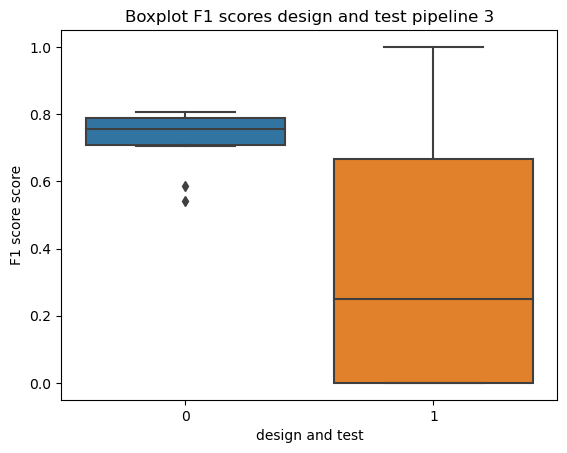

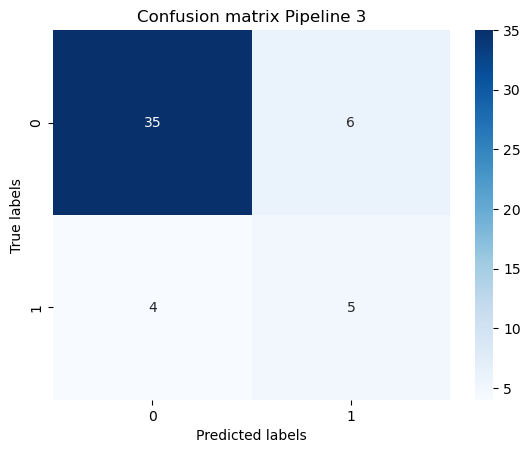

c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


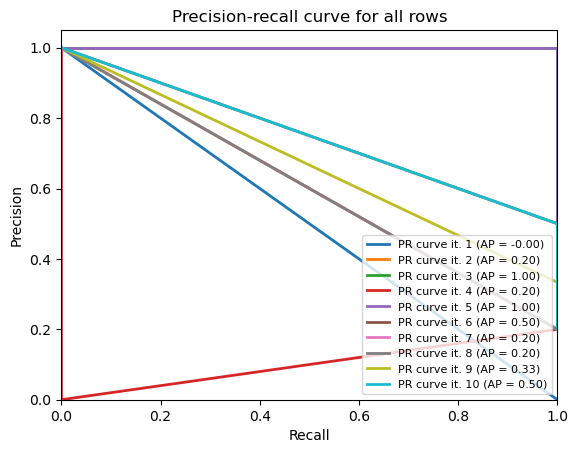

              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.50      0.50      0.50         2
           2       0.50      0.33      0.40         3
           3       0.67      0.67      0.67         3
           4       0.00      0.00      0.00         0

   micro avg       0.45      0.56      0.50         9
   macro avg       0.40      0.50      0.41         9
weighted avg       0.54      0.56      0.52         9
 samples avg       0.33      0.50      0.38         9



c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [208]:
# PIPELINE 3
# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

f1_design_3_before = []
f1_test_3_before = []

f1_design_3_after = []
f1_test_3_after = []

results_3 = pd.DataFrame()
best_pipe_3 = []
best_hp_3_before = pd.DataFrame()
best_hp_3 = pd.DataFrame()

y_test_3_all = []
y_pred_3_all = []

for design_index, test_index in outer_cv.split(X, y): 
    X_design = X.transpose()[design_index]
    X_design = X_design.transpose()
    print(f'Size_X_design {X_design.shape}') # print size of X_design
    y_design = y[design_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_3 = y[test_index].tolist()
    y_test_3_all.append(y_test_3)
    print(f'Size X_test {X_test.shape}')     # print size of X_test
    
    # correct for missing data
    # X_design = missing_data(X_design)
    # X_test = missing_data(X_test)
    # remove outliers
    X_design = removing_outliers(X_design)
    X_test = removing_outliers(X_test)

    # balance the classes, so design set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_design, y_design)
    X_design = X_resampled
    y_design = y_resampled   

    print(f'shape after balancing {X_design.shape}')

    ## PIPELINE 3: RobustScaler --> PCA + univariate --> linear SVM
    
    # Define pipeline 3
    pipeline_3a = Pipeline([
        ('scaler', RobustScaler()),
        ('var_threshold', VarianceThreshold(threshold=0.0)),
        ('pca', PCA(n_components=0.5)),
    ])

    param_grid_3a = {
        'pca__n_components': [0.5],#0.75, 0.9, 0.95, 0.99],
        }

    # Perform grid search with inner cross-validation, part 1
    rand_search_3a = RandomizedSearchCV(pipeline_3a, param_distributions=param_grid_3a, n_iter=10, cv=inner_cv, scoring='f1', n_jobs=-1) #klopt n__iter
    rand_search_3a.fit(X_design, y_design) # klopt dit fit_transform?
    X_design = rand_search_3a.best_estimator_.transform(X_design)
    X_test = rand_search_3a.best_estimator_.transform(X_test)
    
    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_3_before = best_hp_3_before.append(rand_search_3a.best_params_,ignore_index=True)
    print(f'shape of X_design after pca {X_design.shape}')

    # univariate feature selection
    sel_kb = SelectKBest(f_classif, k='all')
    sel_kb.fit(X_design, y_design)
    p_values = sel_kb.pvalues_

    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values, alpha=0.05, method='fdr_bh')
    features_selected=np.array(np.where(reject_fdr)[0])
    print(f'size of features selected{features_selected.shape}')
    X_design = X_design[:,features_selected]
    X_test = X_test[:,features_selected]
        
    print(f'shape of X_design after univariate: {X_design.shape}')
    
    # pipeline 3b
    pipeline_3b = Pipeline([    
        ('clf', SVC(kernel='linear'))
    ])

    # Define scores BEFORE hyperparameter tuning
    pipeline_3b.fit(X_design, y_design)
 
    y_pred_design_3 = pipeline_3b.predict(X_design)
    f1_design_3_bef = f1_score(y_design, y_pred_design_3)
    f1_design_3_before.append(f1_design_3_bef)


    y_pred_test_3_before = pipeline_3b.predict(X_test)
    f1_test_3_bef = f1_score(y_test_3, y_pred_test_3_before)
    f1_test_3_before.append(f1_test_3_bef)

    
    # Define hyperparameters of pipeline 3
    param_grid_3b = {
    'clf__C': np.logspace(-3, 1, 20),
    }

    # Perform grid search with inner cross-validation, part 1
    model_3 = RandomizedSearchCV(pipeline_3b, param_distributions=param_grid_3b, cv=inner_cv, scoring='f1', n_iter=50, n_jobs=-1) # optimize parameters
    model_3.fit(X_design, y_design)

    results = pd.DataFrame(model_3.cv_results_)
    results_3 = results_3.append(results,ignore_index=True)

    # Define scores AFTER hyperparameter tuning 
    y_pred_design_3_after = model_3.predict(X_design)
    f1_design_3_aft = f1_score(y_design, y_pred_design_3_after)
    f1_design_3_after.append(f1_design_3_aft)
   
    y_pred_test_3_after = model_3.predict(X_test)
    y_pred_3_all.append(y_pred_test_3_after)
   
    f1_test_3_aft = f1_score(y_test_3, y_pred_test_3_after)
    f1_test_3_after.append(f1_test_3_aft)


    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_3 = best_hp_3.append(model_3.best_params_,ignore_index=True)
    # Stores the optimum model in best_pipe
    best_pipe_3.append(model_3.best_estimator_)

# Save results of inner CV into .csv file
results_3.to_csv('results_3.csv', index=False)


print(f'Mean and std of F1 scores of pipeline 3: {statistics.mean(f1_test_3_after)} +/- {statistics.stdev(f1_test_3_after)}')


print(f'The optimal hyperparameters per split: {best_hp_3}')
print(f'The best pipes per split {best_pipe_3}')

print(f'The design F1 scores before tuning {f1_design_3_before}')
print(f'The test F1 scores before tuning {f1_test_3_before}')

print(f'The design F1 scores after tuning {f1_design_3_after}')
print(f'The test F1 scores afer tuning {f1_test_3_after}')

data_3 = [f1_design_3_after, f1_test_3_after]
sns.boxplot(data=data_3)
plt.title('Boxplot F1 scores design and test pipeline 3')
plt.xlabel('design and test')
plt.ylabel('F1 score score')
plt.show()


# Loop over rows and compute precision recall curve for each row
for i in range(len(y_pred_3_all)):
    precision, recall, thresholds = precision_recall_curve(y_test_3_all[i], y_pred_3_all[i])
    auc = average_precision_score(y_test_3_all[i], y_pred_3_all[i])


    # Plot the ROC curve for each row
    plt.plot(recall, precision, lw=2, label='PR curve it. %d (AP = %0.2f)' % (i+1, auc))


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve for all rows')
plt.legend(loc="lower right", fontsize=8)
plt.show()


# from sklearn.metrics import classification_report
# print(classification_report(y_test_3_all, y_pred_3_all))



### PIPELINE 4
- PCA-UNI --> KNN

In [222]:
cwd = os.getcwd() # This fn will return the Current Working Directory

zip_path = os.path.join(cwd, 'ecg', 'ecg_data.zip')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(cwd, 'ecg'))

data_path = os.path.join(cwd, 'ecg', 'ecg_data.csv')
data = pd.read_csv(data_path, index_col=0)

# split labels from data
X = data.loc[:, data.columns != 'label']  #alles behalve label
y = data['label']  # labels

# X = X.iloc[:50, :4000]
# y = y.iloc[:50]

Size_X_design (25, 4000)
Size X_test (25, 4000)
The total number of outliers in dataset x is 3464
The total number of outliers in dataset x is 4728
shape after balancing (40, 4000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1599859380.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_4_before = best_hp_4_before.append(rand_search_4a.best_params_,ignore_index=True)


shape of X_design after pca (40, 3)
size of features selected(2,)
shape of X_design after univariate: (40, 2)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1599859380.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_4 = results_4.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1599859380.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_4 = best_hp_4.append(model_4.best_params_,ignore_index=True)


Size_X_design (25, 4000)
Size X_test (25, 4000)
The total number of outliers in dataset x is 4728
The total number of outliers in dataset x is 3464
shape after balancing (42, 4000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1599859380.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_4_before = best_hp_4_before.append(rand_search_4a.best_params_,ignore_index=True)


shape of X_design after pca (42, 3)
size of features selected(1,)
shape of X_design after univariate: (42, 1)
Mean and std of F1 scores of pipeline 4: 0.30952380952380953 +/- 0.03367175148507369
The optimal hyperparameters per split:    clf__p  clf__n_neighbors  clf__leaf_size
0       1                 8              15
1       1                 4               6
The best pipes per split [Pipeline(steps=[('clf',
                 KNeighborsClassifier(leaf_size=15, n_neighbors=8, p=1))]), Pipeline(steps=[('clf', KNeighborsClassifier(leaf_size=6, n_neighbors=4, p=1))])]
The design F1 scores before tuning [0.9, 0.8400000000000001]
The test F1 scores before tuning [0.3333333333333333, 0.26666666666666666]
The design F1 scores after tuning [0.888888888888889, 0.8936170212765957]
The test F1 scores afer tuning [0.3333333333333333, 0.2857142857142857]


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1599859380.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_4 = results_4.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1599859380.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_4 = best_hp_4.append(model_4.best_params_,ignore_index=True)


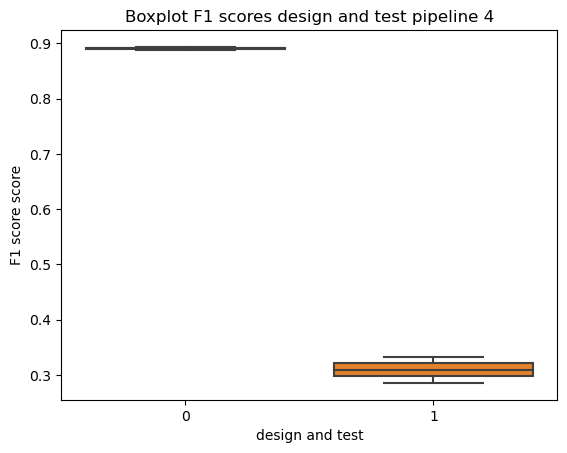

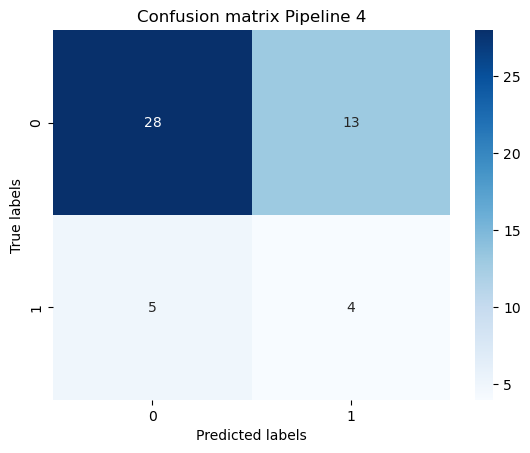

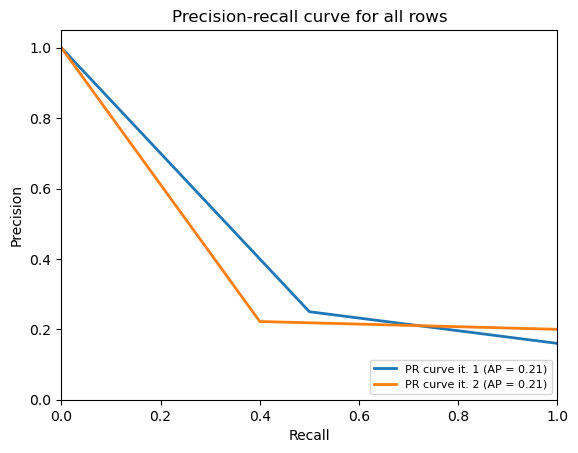

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       1.00      1.00      1.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       1.00      0.50      0.67         2
          16       0.00      0.00      0.00         0
          17       1.00    

c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [224]:
# PIPELINE 4
# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

f1_design_4_before = []
f1_test_4_before = []

f1_design_4_after = []
f1_test_4_after = []

results_4 = pd.DataFrame()
best_pipe_4 = []
best_hp_4_before = pd.DataFrame()
best_hp_4 = pd.DataFrame()

y_test_4_all = []
y_pred_4_all = []

for design_index, test_index in outer_cv.split(X, y): 
    X_design = X.transpose()[design_index]
    X_design = X_design.transpose()
    print(f'Size_X_design {X_design.shape}') # print size of X_design
    y_design = y[design_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_4 = y[test_index].tolist()
    y_test_4_all.append(y_test_4)
    print(f'Size X_test {X_test.shape}')     # print size of X_test
    
    # correct for missing data
    # X_design = missing_data(X_design)
    # X_test = missing_data(X_test)
    # remove outliers
    X_design = removing_outliers(X_design)
    X_test = removing_outliers(X_test)

    # balance the classes, so design set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_design, y_design)
    X_design = X_resampled
    y_design = y_resampled   

    print(f'shape after balancing {X_design.shape}')

    ## PIPELINE 4: RobustScaler --> PCA + univariate --> KNN
    
    # Define pipeline 4a
    pipeline_4a = Pipeline([
        ('scaler', RobustScaler()),
        ('var_threshold', VarianceThreshold(threshold=0.0)),
        ('pca', PCA(n_components=0.5)),
    ])

    param_grid_4a = {
        'pca__n_components': [0.5],#0.75, 0.9, 0.95, 0.99],
        }

    # Perform grid search with inner cross-validation, part 1
    rand_search_4a = RandomizedSearchCV(pipeline_4a, param_distributions=param_grid_4a, n_iter=10, cv=inner_cv, scoring='f1', n_jobs=-1) #klopt n__iter
    rand_search_4a.fit(X_design, y_design) # klopt dit fit_transform?
    X_design = rand_search_4a.best_estimator_.transform(X_design)
    X_test = rand_search_4a.best_estimator_.transform(X_test)
    
    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_4_before = best_hp_4_before.append(rand_search_4a.best_params_,ignore_index=True)
    print(f'shape of X_design after pca {X_design.shape}')

    # univariate feature selection
    sel_kb = SelectKBest(f_classif, k='all')
    sel_kb.fit(X_design, y_design)
    p_values = sel_kb.pvalues_

    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values, alpha=0.05, method='fdr_bh')
    features_selected=np.array(np.where(reject_fdr)[0])
    print(f'size of features selected{features_selected.shape}')
    X_design = X_design[:,features_selected]
    X_test = X_test[:,features_selected]
        
    print(f'shape of X_design after univariate: {X_design.shape}')
    
    # pipeline 4b
    pipeline_4b = Pipeline([    
        ('clf', KNeighborsClassifier())
    ])

    # Define scores BEFORE hyperparameter tuning
    pipeline_4b.fit(X_design, y_design)
 
    y_pred_design_4 = pipeline_4b.predict(X_design)
    f1_design_4_bef = f1_score(y_design, y_pred_design_4)
    f1_design_4_before.append(f1_design_4_bef)


    y_pred_test_4_before = pipeline_4b.predict(X_test)
    f1_test_4_bef = f1_score(y_test_4, y_pred_test_4_before)
    f1_test_4_before.append(f1_test_4_bef)

    
    # Define hyperparameters of pipeline 4
    param_grid_4b = {
    'clf__n_neighbors': list(range(4,26,2)), # op 4 begonnen, want uit learning curves bleek dat vanaf 5 goede fit en lager slechte fit
    'clf__p': [1,2],
    'clf__leaf_size': np.arange(1,26,1)
    }

    # Perform grid search with inner cross-validation, part 1
    model_4 = RandomizedSearchCV(pipeline_4b, param_distributions=param_grid_4b, cv=inner_cv, scoring='f1', n_iter= 50, n_jobs=-1) # optimize parameters
    model_4.fit(X_design, y_design)

    results = pd.DataFrame(model_4.cv_results_)
    results_4 = results_4.append(results,ignore_index=True)

    # Define scores AFTER hyperparameter tuning 
    y_pred_design_4_after = model_4.predict(X_design)
    f1_design_4_aft = f1_score(y_design, y_pred_design_4_after)
    f1_design_4_after.append(f1_design_4_aft)
   
    y_pred_test_4_after = model_4.predict(X_test)
    y_pred_4_all.append(y_pred_test_4_after)
   
    f1_test_4_aft = f1_score(y_test_4, y_pred_test_4_after)
    f1_test_4_after.append(f1_test_4_aft)

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_4 = best_hp_4.append(model_4.best_params_,ignore_index=True)
    # Stores the optimum model in best_pipe
    best_pipe_4.append(model_4.best_estimator_)

# Save results of inner CV into .csv file
results_4.to_csv('results_4.csv', index=False)


print(f'Mean and std of F1 scores of pipeline 4: {statistics.mean(f1_test_4_after)} +/- {statistics.stdev(f1_test_4_after)}')


print(f'The optimal hyperparameters per split: {best_hp_4}')
print(f'The best pipes per split {best_pipe_4}')


print(f'The design F1 scores before tuning {f1_design_4_before}')
print(f'The test F1 scores before tuning {f1_test_4_before}')


print(f'The design F1 scores after tuning {f1_design_4_after}')
print(f'The test F1 scores afer tuning {f1_test_4_after}')




data_4 = [f1_design_4_after, f1_test_4_after]
sns.boxplot(data=data_4)
plt.title('Boxplot F1 scores design and test pipeline 4')
plt.xlabel('design and test')
plt.ylabel('F1 score score')
plt.show()


# Confusion matrix
# convert numpy arrays to Python lists
y_pred_4_all = [arr.tolist() for arr in y_pred_4_all]
y_test_4_all = np.array(y_test_4_all)
y_pred_4_all = np.array(y_pred_4_all)
y_test_4_all_confusion = [item for sublist in y_test_4_all for item in sublist]
y_pred_4_all_confusion = [item for sublist in y_pred_4_all for item in sublist]

# Loop over rows and compute precision recall curve for each row
for i in range(len(y_pred_4_all)):
    precision, recall, thresholds = precision_recall_curve(y_test_4_all[i], y_pred_4_all[i])
    auc = average_precision_score(y_test_4_all[i], y_pred_4_all[i])


    # Plot the ROC curve for each row
    plt.plot(recall, precision, lw=2, label='PR curve it. %d (AP = %0.2f)' % (i+1, auc))


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve for all rows')
plt.legend(loc="lower right", fontsize=8)
plt.show()


# from sklearn.metrics import classification_report
# print(classification_report(y_test_4_all, y_pred_4_all))


In [211]:
print(y_pred_4_all)
print(y_test_4_all)

[list([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
 list([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1])
 list([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])]
[list([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0])
 list([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0])
 list([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])]


### PIPELINE 5 
- LASSO --> KNN

In [ ]:
cwd = os.getcwd() # This fn will return the Current Working Directory

zip_path = os.path.join(cwd, 'ecg', 'ecg_data.zip')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(cwd, 'ecg'))

data_path = os.path.join(cwd, 'ecg', 'ecg_data.csv')
data = pd.read_csv(data_path, index_col=0)

# split labels from data
X = data.loc[:, data.columns != 'label']  #alles behalve label
y = data['label']  # labels

# X = X.iloc[:50, :2000]
# y = y.iloc[:50]

Size_X_design (33, 4000)
Size X_test (17, 4000)
The total number of outliers in dataset x is 6800
The total number of outliers in dataset x is 1998
shape after balancing (54, 4000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\375662915.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5_before = best_hp_5_before.append(rand_search_5a.best_params_,ignore_index=True)


This is the size of X_design after LASSO: (54, 3978)
This is the size of X_design after LASSO: (54, 3978)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\375662915.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_5 = results_5.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\375662915.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5 = best_hp_5.append(model_5.best_params_,ignore_index=True)


Size_X_design (33, 4000)
Size X_test (17, 4000)
The total number of outliers in dataset x is 3950
The total number of outliers in dataset x is 4360
shape after balancing (54, 4000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\375662915.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5_before = best_hp_5_before.append(rand_search_5a.best_params_,ignore_index=True)


This is the size of X_design after LASSO: (54, 3238)
This is the size of X_design after LASSO: (54, 3238)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\375662915.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_5 = results_5.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\375662915.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5 = best_hp_5.append(model_5.best_params_,ignore_index=True)


Size_X_design (34, 4000)
Size X_test (16, 4000)
The total number of outliers in dataset x is 5892
The total number of outliers in dataset x is 2830
shape after balancing (56, 4000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\375662915.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5_before = best_hp_5_before.append(rand_search_5a.best_params_,ignore_index=True)


This is the size of X_design after LASSO: (56, 3145)
This is the size of X_design after LASSO: (56, 3145)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\375662915.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_5 = results_5.append(results,ignore_index=True)


Mean and std of F1 scores of pipeline 5: 0.43333333333333335 +/- 0.05773502691896256
The optimal hyperparameters per split:    clf__p  clf__n_neighbors  clf__leaf_size
0       1                 8               7
1       1                 4              18
2       2                20              20
The best pipes per split [Pipeline(steps=[('clf', KNeighborsClassifier(leaf_size=7, n_neighbors=8, p=1))]), Pipeline(steps=[('clf',
                 KNeighborsClassifier(leaf_size=18, n_neighbors=4, p=1))]), Pipeline(steps=[('clf', KNeighborsClassifier(leaf_size=20, n_neighbors=20))])]
The design F1 scores before tuning [0.8771929824561403, 0.7941176470588235, 0.7878787878787878]
The test F1 scores before tuning [0.3333333333333333, 0.4, 0.2]
The design F1 scores after tuning [0.8771929824561403, 0.9, 0.7307692307692307]
The test F1 scores afer tuning [0.4, 0.4, 0.5]


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\375662915.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5 = best_hp_5.append(model_5.best_params_,ignore_index=True)


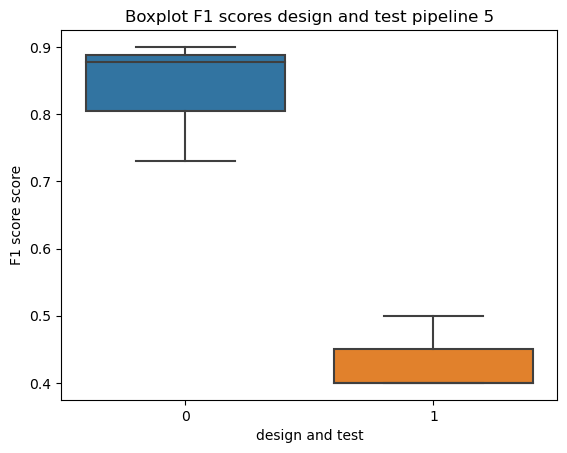

C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\375662915.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_test_5_all = np.array(y_test_5_all)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\375662915.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_pred_5_all = np.array(y_pred_5_all)


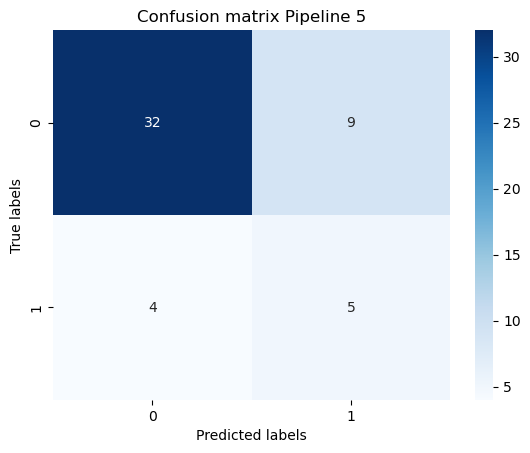

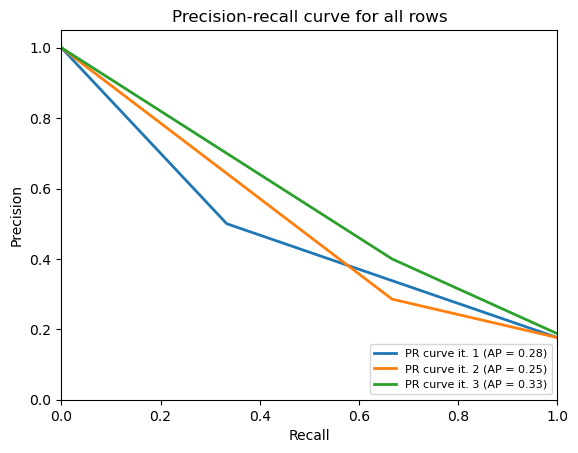

ValueError: You appear to be using a legacy multi-label data representation. Sequence of sequences are no longer supported; use a binary array or sparse matrix instead - the MultiLabelBinarizer transformer can convert to this format.

In [225]:
# PIPELINE 5

# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

f1_design_5_before = []
f1_test_5_before = []


f1_design_5_after = []
f1_test_5_after = []

results_5 = pd.DataFrame()
best_pipe_5 = []
best_hp_5_before = pd.DataFrame()
best_hp_5 = pd.DataFrame()

y_test_5_all = []
y_pred_5_all = []

for design_index, test_index in outer_cv.split(X, y): 
    X_design = X.transpose()[design_index]
    X_design = X_design.transpose()
    print(f'Size_X_design {X_design.shape}') # print size of X_design
    y_design = y[design_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_5 = y[test_index].tolist()
    y_test_5_all.append(y_test_5)
    print(f'Size X_test {X_test.shape}')     # print size of X_test
    
    # correct for missing data
    # X_design = missing_data(X_design)
    # X_test = missing_data(X_test)
    # remove outliers
    X_design = removing_outliers(X_design)
    X_test = removing_outliers(X_test)

    # balance the classes, so design set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_design, y_design)
    X_design = X_resampled
    y_design = y_resampled   

    print(f'shape after balancing {X_design.shape}')  

    # Scaling the data
    scaler = RobustScaler()
    X_design = scaler.fit_transform(X_design)
    X_test = scaler.transform(X_test)

    ## PIPELINE 5: RobustScaler --> LASSO --> KNN
    # Define pipeline 5
    pipeline_5a = Pipeline([
        ('lasso', Lasso()),
    ])
    # Define hyperparameters of pipeline 5
    param_grid_5a = {
    'lasso__alpha': np.logspace(-10, 1, 100),
    }

    # Perform randomized search with inner cross-validation to find best alpha
    rand_search_5a = RandomizedSearchCV(pipeline_5a, param_distributions=param_grid_5a, n_iter=50, cv=inner_cv, scoring='f1',n_jobs=-1) # optimize parameters
    rand_search_5a.fit(X_design, y_design)
    
    # Create a new Lasso model using the best alpha value
    lasso = Lasso(alpha=rand_search_5a.best_params_['lasso__alpha'])
    lasso.fit(X_design, y_design)

    # Get the coefficients of the Lasso model, find them and define the new X_design with less features
    coef = lasso.coef_
    selected_features = np.where(coef != 0)[0]
    X_design = X_design[:, selected_features]
    X_test = X_test[:, selected_features]
    print(f'This is the size of X_design after LASSO: {X_design.shape}')

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_5_before = best_hp_5_before.append(rand_search_5a.best_params_,ignore_index=True)
    
    print(f'This is the size of X_design after LASSO: {X_design.shape}')

## PIPELINE 5: RF
    # Define pipeline 5b
    pipeline_5b = Pipeline([
        ('clf', KNeighborsClassifier())
        ])
    
    # Define scores BEFORE hyperparameter tuning
    pipeline_5b.fit(X_design, y_design)
 
    y_pred_design_5 = pipeline_5b.predict(X_design)
    f1_design_5_bef = f1_score(y_design, y_pred_design_5)
    f1_design_5_before.append(f1_design_5_bef)

    y_pred_test_5_before = pipeline_5b.predict(X_test)
    f1_test_5_bef = f1_score(y_test_5, y_pred_test_5_before)
    f1_test_5_before.append(f1_test_5_bef)

    # Define hyperparameters of pipeline 5b
    param_grid_5b = {'clf__n_neighbors': list(range(4,26,2)),
                  'clf__p': [1,2],
                  'clf__leaf_size': np.arange(1,26,1)
                }

    # Perform grid search with inner cross-validation, part 1
    model_5 = RandomizedSearchCV(pipeline_5b, param_distributions=param_grid_5b, n_iter=50, cv=inner_cv, scoring='f1', n_jobs=-1) # optimize parameters
    model_5.fit(X_design, y_design)

    # Storing results cross-validation
    results = pd.DataFrame(model_5.cv_results_)
    results_5 = results_5.append(results,ignore_index=True)

    # Define scores AFTER hyperparameter tuning 
    y_pred_design_5_after = model_5.predict(X_design)
    f1_design_5_aft = f1_score(y_design, y_pred_design_5_after)
    f1_design_5_after.append(f1_design_5_aft)
   
    y_pred_test_5_after = model_5.predict(X_test)
    y_pred_5_all.append(y_pred_test_5_after)
   
    f1_test_5_aft = f1_score(y_test_5, y_pred_test_5_after)
    f1_test_5_after.append(f1_test_5_aft)

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_5 = best_hp_5.append(model_5.best_params_,ignore_index=True)
    # Stores the optimum model in best_pipe
    best_pipe_5.append(model_5.best_estimator_)

# Save results of inner CV into .csv file
results_5.to_csv('results_5.csv', index=False)


print(f'Mean and std of F1 scores of pipeline 5: {statistics.mean(f1_test_5_after)} +/- {statistics.stdev(f1_test_5_after)}')


print(f'The optimal hyperparameters per split: {best_hp_5}')
print(f'The best pipes per split {best_pipe_5}')


print(f'The design F1 scores before tuning {f1_design_5_before}')
print(f'The test F1 scores before tuning {f1_test_5_before}')


print(f'The design F1 scores after tuning {f1_design_5_after}')
print(f'The test F1 scores afer tuning {f1_test_5_after}')




data_5 = [f1_design_5_after, f1_test_5_after]
sns.boxplot(data=data_5)
plt.title('Boxplot F1 scores design and test pipeline 5')
plt.xlabel('design and test')
plt.ylabel('F1 score score')
plt.show()

# Loop over rows and compute precision recall curve for each row
for i in range(len(y_pred_5_all)):
    precision, recall, thresholds = precision_recall_curve(y_test_5_all[i], y_pred_5_all[i])
    auc = average_precision_score(y_test_5_all[i], y_pred_5_all[i])


    # Plot the ROC curve for each row
    plt.plot(recall, precision, lw=2, label='PR curve it. %d (AP = %0.2f)' % (i+1, auc))


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve for all rows')
plt.legend(loc="lower right", fontsize=8)
plt.show()


# from sklearn.metrics import classification_report
# print(classification_report(y_test_5_all, y_pred_5_all))


### PIPELINE 6
- PCA-UNI --> Random Forest

In [230]:
cwd = os.getcwd() # This fn will return the Current Working Directory

zip_path = os.path.join(cwd, 'ecg', 'ecg_data.zip')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(cwd, 'ecg'))

data_path = os.path.join(cwd, 'ecg', 'ecg_data.csv')
data = pd.read_csv(data_path, index_col=0)

# split labels from data
X = data.loc[:, data.columns != 'label']  #alles behalve label
y = data['label']  # labels

# X = X.iloc[:50, :2000]
# y = y.iloc[:50]

In [231]:
# PIPELINE 6
# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

f1_design_6_before = []
f1_test_6_before = []


f1_design_6_after = []
f1_test_6_after = []


results_6 = pd.DataFrame()
best_pipe_6 = []
best_hp_6_before = pd.DataFrame()
best_hp_6 = pd.DataFrame()

y_test_6_all = []
y_pred_6_all = []

for design_index, test_index in outer_cv.split(X, y): 
    X_design = X.transpose()[design_index]
    X_design = X_design.transpose()
    print(f'Size_X_design {X_design.shape}') # print size of X_design
    y_design = y[design_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_6 = y[test_index].tolist()
    y_test_6_all.append(y_test_6)
    print(f'Size X_test {X_test.shape}')     # print size of X_test
    
    # correct for missing data
    # X_design = missing_data(X_design)
    # X_test = missing_data(X_test)
    # remove outliers
    X_design = removing_outliers(X_design)
    X_test = removing_outliers(X_test)

    # balance the classes, so design set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_design, y_design)
    X_design = X_resampled
    y_design = y_resampled   

    print(f'shape after balancing {X_design.shape}')

    ## PIPELINE 6: RobustScaler --> PCA + univariate --> RF
    
    # Define pipeline 6a
    pipeline_6a = Pipeline([
        ('scaler', RobustScaler()),
        ('var_threshold', VarianceThreshold(threshold=0.0)),
        ('pca', PCA(n_components=0.5)),
    ])

    param_grid_6a = {
        'pca__n_components': [0.5],#,0.75, 0.9, 0.95, 0.99],
        }

    # Perform grid search with inner cross-validation, part 1
    rand_search_6a = RandomizedSearchCV(pipeline_6a, param_distributions=param_grid_6a, n_iter=10, cv=inner_cv, scoring='f1', n_jobs=-1) #klopt n__iter
    rand_search_6a.fit(X_design, y_design)
    X_design = rand_search_6a.best_estimator_.transform(X_design)
    X_test = rand_search_6a.best_estimator_.transform(X_test)
    
    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_6_before = best_hp_6_before.append(rand_search_6a.best_params_,ignore_index=True)
    print(f'shape of X_design after pca {X_design.shape}')

    # univariate feature selection
    sel_kb = SelectKBest(f_classif, k='all')
    sel_kb.fit(X_design, y_design)
    p_values = sel_kb.pvalues_

    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values, alpha=0.05, method='fdr_bh')
    features_selected=np.array(np.where(reject_fdr)[0])
    print(f'size of features selected{features_selected.shape}')
    X_design = X_design[:,features_selected]
    X_test = X_test[:,features_selected]
        
    print(f'shape of X_design after univariate: {X_design.shape}')
    
    # pipeline 6b
    pipeline_6b = Pipeline([    
        ('clf', RandomForestClassifier())
    ])

    # Define scores BEFORE hyperparameter tuning
    pipeline_6b.fit(X_design, y_design)
 
    y_pred_design_6 = pipeline_6b.predict(X_design)
    f1_design_6_bef = f1_score(y_design, y_pred_design_6)
    f1_design_6_before.append(f1_design_6_bef)


    y_pred_test_6_before = pipeline_6b.predict(X_test)
    f1_test_6_bef = f1_score(y_test_6, y_pred_test_6_before)
    f1_test_6_before.append(f1_test_6_bef)
    
    # Define hyperparameters of pipeline 6
    param_grid_6b = {'clf__n_estimators' : range(2,6),
                    'clf__criterion' :['gini','entropy','log_loss'],
                    'clf__min_samples_split':range(2,10),
                    'clf__min_samples_leaf':range(1,10),
                    'clf__min_weight_fraction_leaf' : np.linspace(0, 0.5, 25),
                    'clf__max_features':['sqrt','log2',None],
                    'clf__bootstrap':[True,False],
                    'clf__warm_start':[True,False]
                    }

    # Perform grid search with inner cross-validation, part 1
    model_6 = RandomizedSearchCV(pipeline_6b, param_distributions=param_grid_6b, cv=inner_cv, scoring='f1', n_iter=50, n_jobs=-1) # optimize parameters
    model_6.fit(X_design, y_design)

    results = pd.DataFrame(model_6.cv_results_)
    results_6 = results_6.append(results,ignore_index=True)

    # Define scores AFTER hyperparameter tuning 
    y_pred_design_6_after = model_6.predict(X_design)
    f1_design_6_aft = f1_score(y_design, y_pred_design_6_after)
    f1_design_6_after.append(f1_design_6_aft)
   
    y_pred_test_6_after = model_6.predict(X_test)
    y_pred_6_all.append(y_pred_test_6_after)
   
    f1_test_6_aft = f1_score(y_test_6, y_pred_test_6_after)
    f1_test_6_after.append(f1_test_6_aft)

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_6 = best_hp_6.append(model_6.best_params_,ignore_index=True)
    # Stores the optimum model in best_pipe
    best_pipe_6.append(model_6.best_estimator_)

# Save results of inner CV into .csv file
results_6.to_csv('results_6.csv', index=False)


print(f'Mean and std of F1 scores of pipeline 1: {statistics.mean(f1_test_6_after)} +/- {statistics.stdev(f1_test_6_after)}')


print(f'The optimal hyperparameters per split: {best_hp_6}')
print(f'The best pipes per split {best_pipe_6}')


print(f'The design F1 scores before tuning {f1_design_6_before}')
print(f'The test F1 scores before tuning {f1_test_6_before}')


print(f'The design F1 scores after tuning {f1_design_6_after}')
print(f'The test F1 scores afer tuning {f1_test_6_after}')




data_6 = [f1_design_6_after, f1_test_6_after]
sns.boxplot(data=data_6)
plt.title('Boxplot F1 scores design and test pipeline 6')
plt.xlabel('design and test')
plt.ylabel('F1 score score')
plt.show()


# Loop over rows and compute precision recall curve for each row
for i in range(len(y_pred_6_all)):
    precision, recall, thresholds = precision_recall_curve(y_test_6_all[i], y_pred_6_all[i])
    auc = average_precision_score(y_test_6_all[i], y_pred_6_all[i])


    # Plot the ROC curve for each row
    plt.plot(recall, precision, lw=2, label='PR curve it. %d (AP = %0.2f)' % (i+1, auc))


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve for all rows')
plt.legend(loc="lower right", fontsize=8)
plt.show()


# from sklearn.metrics import classification_report
# print(classification_report(y_test_6_all, y_pred_6_all))

Size_X_design (45, 2000)
Size X_test (5, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


The total number of outliers in dataset x is 3886
The total number of outliers in dataset x is 1012
shape after balancing (72, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1459649159.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_6_before = best_hp_6_before.append(rand_search_6a.best_params_,ignore_index=True)
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is"

shape of X_design after pca (72, 3)
size of features selected(1,)
shape of X_design after univariate: (72, 1)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1459649159.py:118: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_6 = results_6.append(results,ignore_index=True)
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1459649159.py:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_6 = best_hp_6.append(model_6.best_params_,ignore_index=True)


Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3694
The total number of outliers in dataset x is 874
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1459649159.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_6_before = best_hp_6_before.append(rand_search_6a.best_params_,ignore_index=True)


shape of X_design after pca (74, 3)
size of features selected(2,)
shape of X_design after univariate: (74, 2)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\1459649159.py:118: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_6 = results_6.append(results,ignore_index=True)


ValueError: X has 2 features, but GaussianNB is expecting 1 features as input.

### PIPELINE 7
- LASSO --> Random Forest

In [232]:
cwd = os.getcwd() # This fn will return the Current Working Directory

zip_path = os.path.join(cwd, 'ecg', 'ecg_data.zip')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(cwd, 'ecg'))

data_path = os.path.join(cwd, 'ecg', 'ecg_data.csv')
data = pd.read_csv(data_path, index_col=0)

# split labels from data
X = data.loc[:, data.columns != 'label']  #alles behalve label
y = data['label']  # labels

# X = X.iloc[:50, :2000]
# y = y.iloc[:50]

c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3886
The total number of outliers in dataset x is 1012
shape after balancing (72, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7_before = best_hp_7_before.append(rand_search_7a.best_params_,ignore_index=True)


This is the size of X_design after LASSO: (72, 1999)
This is the size of X_design after LASSO: (72, 1999)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_7 = results_7.append(results,ignore_index=True)
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:134: FutureWarning: The frame.append metho

Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3694
The total number of outliers in dataset x is 874
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7_before = best_hp_7_before.append(rand_search_7a.best_params_,ignore_index=True)


This is the size of X_design after LASSO: (74, 2000)
This is the size of X_design after LASSO: (74, 2000)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_7 = results_7.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7 = best_hp_7.append(model_7.best_params_,ignore_index=True)


Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3812
The total number of outliers in dataset x is 734
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.520e-03, tolerance: 1.850e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.52

This is the size of X_design after LASSO: (74, 512)
This is the size of X_design after LASSO: (74, 512)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_7 = results_7.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7 = best_hp_7.append(model_7.best_params_,ignore_index=True)


Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3198
The total number of outliers in dataset x is 900
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.030e-03, tolerance: 1.850e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.03

This is the size of X_design after LASSO: (74, 386)
This is the size of X_design after LASSO: (74, 386)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_7 = results_7.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7 = best_hp_7.append(model_7.best_params_,ignore_index=True)


Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3038
The total number of outliers in dataset x is 1502
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7_before = best_hp_7_before.append(rand_search_7a.best_params_,ignore_index=True)


This is the size of X_design after LASSO: (74, 1996)
This is the size of X_design after LASSO: (74, 1996)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_7 = results_7.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7 = best_hp_7.append(model_7.best_params_,ignore_index=True)


Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 4040
The total number of outliers in dataset x is 650
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.966e-03, tolerance: 1.850e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.96

This is the size of X_design after LASSO: (74, 48)
This is the size of X_design after LASSO: (74, 48)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_7 = results_7.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7 = best_hp_7.append(model_7.best_params_,ignore_index=True)


Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3454
The total number of outliers in dataset x is 1230
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7_before = best_hp_7_before.append(rand_search_7a.best_params_,ignore_index=True)


This is the size of X_design after LASSO: (74, 1999)
This is the size of X_design after LASSO: (74, 1999)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_7 = results_7.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7 = best_hp_7.append(model_7.best_params_,ignore_index=True)


Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3660
The total number of outliers in dataset x is 752
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7_before = best_hp_7_before.append(rand_search_7a.best_params_,ignore_index=True)


This is the size of X_design after LASSO: (74, 2000)
This is the size of X_design after LASSO: (74, 2000)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_7 = results_7.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7 = best_hp_7.append(model_7.best_params_,ignore_index=True)


Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 3216
The total number of outliers in dataset x is 916
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7_before = best_hp_7_before.append(rand_search_7a.best_params_,ignore_index=True)


This is the size of X_design after LASSO: (74, 1988)
This is the size of X_design after LASSO: (74, 1988)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_7 = results_7.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7 = best_hp_7.append(model_7.best_params_,ignore_index=True)


Size_X_design (45, 2000)
Size X_test (5, 2000)
The total number of outliers in dataset x is 4186
The total number of outliers in dataset x is 568
shape after balancing (74, 2000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.982e-03, tolerance: 1.850e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.98

This is the size of X_design after LASSO: (74, 106)
This is the size of X_design after LASSO: (74, 106)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_7 = results_7.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\58125668.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7 = best_hp_7.append(model_7.best_params_,ignore_index=True)


Mean and std of F1 scores of pipeline 7: 0.05 +/- 0.15811388300841897
The optimal hyperparameters per split:    clf__warm_start  clf__n_estimators  clf__min_weight_fraction_leaf  \
0            False                701                       0.104167   
1             True                977                       0.083333   
2             True                591                       0.020833   
3            False                970                       0.208333   
4             True                624                       0.062500   
5            False                529                       0.083333   
6             True                867                       0.083333   
7            False                150                       0.104167   
8             True                842                       0.041667   
9             True                748                       0.062500   

   clf__min_samples_split  clf__min_samples_leaf clf__max_features  \
0                       7   

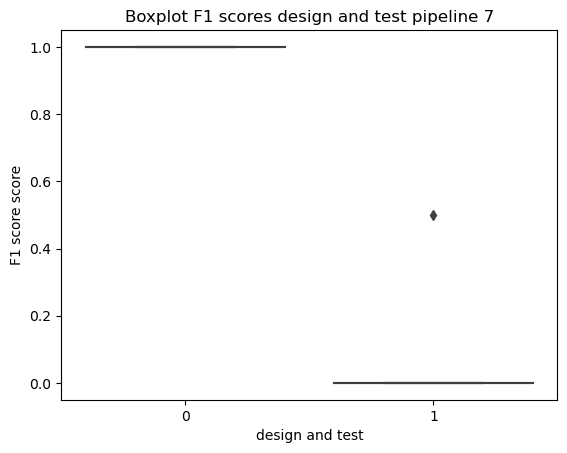

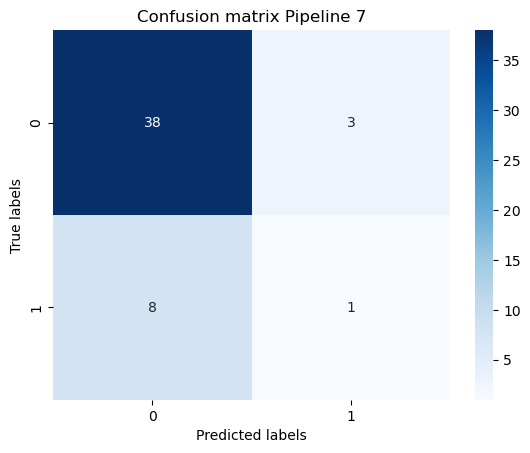

c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


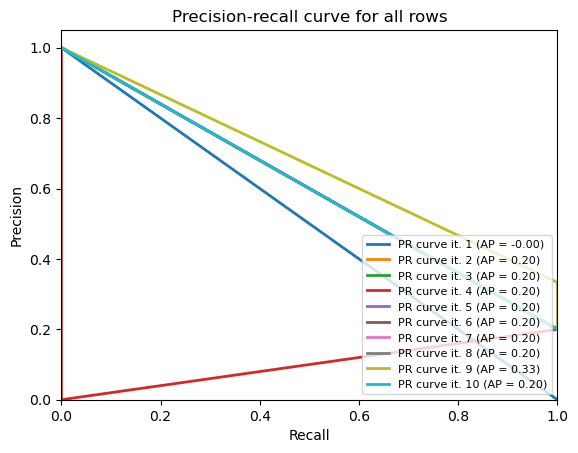

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         0

   micro avg       0.25      0.11      0.15         9
   macro avg       0.20      0.20      0.20         9
weighted avg       0.11      0.11      0.11         9
 samples avg       0.03      0.10      0.05         9



c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\

In [233]:
# PIPELINE 7

# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

f1_design_7_before = []
f1_test_7_before = []


f1_design_7_after = []
f1_test_7_after = []


results_7 = pd.DataFrame()
best_pipe_7 = []
best_hp_7_before = pd.DataFrame()
best_hp_7 = pd.DataFrame()

y_test_7_all = []
y_pred_7_all = []

for design_index, test_index in outer_cv.split(X, y): 
    X_design = X.transpose()[design_index]
    X_design = X_design.transpose()
    print(f'Size_X_design {X_design.shape}') # print size of X_design
    y_design = y[design_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_7 = y[test_index].tolist()
    y_test_7_all.append(y_test_7)
    print(f'Size X_test {X_test.shape}')     # print size of X_test
    
    # correct for missing data
    # X_design = missing_data(X_design)
    # X_test = missing_data(X_test)
    # remove outliers
    X_design = removing_outliers(X_design)
    X_test = removing_outliers(X_test)

    # balance the classes, so design set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_design, y_design)
    X_design = X_resampled
    y_design = y_resampled   

    print(f'shape after balancing {X_design.shape}')  

    # Scaling the data
    scaler = RobustScaler()
    X_design = scaler.fit_transform(X_design)
    X_test = scaler.transform(X_test)

    ## PIPELINE 7: RobustScaler --> LASSO --> RF
    # Define pipeline 7
    pipeline_7a = Pipeline([
        ('lasso', Lasso()),
    ])
    # Define hyperparameters of pipeline 5
    param_grid_7a = {
    'lasso__alpha': np.logspace(-10, 1, 100),
    }

    # Perform randomized search with inner cross-validation to find best alpha
    rand_search_7a = RandomizedSearchCV(pipeline_7a, param_distributions=param_grid_7a, n_iter =50, cv=inner_cv, scoring='f1',n_jobs=-1) # optimize parameters
    rand_search_7a.fit(X_design, y_design)
    
    # Create a new Lasso model using the best alpha value
    lasso = Lasso(alpha=rand_search_7a.best_params_['lasso__alpha'])
    lasso.fit(X_design, y_design)

    # Get the coefficients of the Lasso model, find them and define the new X_design with less features
    coef = lasso.coef_
    selected_features = np.where(coef != 0)[0]
    X_design = X_design[:, selected_features]
    X_test = X_test[:, selected_features]
    print(f'This is the size of X_design after LASSO: {X_design.shape}')

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_7_before = best_hp_7_before.append(rand_search_7a.best_params_,ignore_index=True)
    
    print(f'This is the size of X_design after LASSO: {X_design.shape}')

## PIPELINE 7: RF
    # Define pipeline 7b
    pipeline_7b = Pipeline([
        ('clf', RandomForestClassifier())])
    
    # Define scores BEFORE hyperparameter tuning
    pipeline_7b.fit(X_design, y_design)
 
    y_pred_design_7 = pipeline_7b.predict(X_design)
    f1_design_7_bef = f1_score(y_design, y_pred_design_7)
    f1_design_7_before.append(f1_design_7_bef)


    y_pred_test_7_before = pipeline_7b.predict(X_test)
    f1_test_7_bef = f1_score(y_test_7, y_pred_test_7_before)
    f1_test_7_before.append(f1_test_7_bef)


    # Define hyperparameters of pipeline 7b
    param_grid_7b = {'clf__n_estimators' : range(2,6),
                               'clf__criterion' :['gini','entropy','log_loss'],
                               'clf__min_samples_split':range(2,10),
                               'clf__min_samples_leaf':range(1,10),
                               'clf__min_weight_fraction_leaf' : np.linspace(0, 0.5, 25),
                               'clf__max_features':['sqrt','log2',None],
                               'clf__bootstrap':[True,False],
                               'clf__warm_start':[True,False],
                               }

    # Perform grid search with inner cross-validation, part 1
    model_7 = RandomizedSearchCV(pipeline_7b, param_distributions=param_grid_7b, n_iter=50, cv=inner_cv, scoring='f1', n_jobs=-1) # optimize parameters
    model_7.fit(X_design, y_design)

    # Storing results cross-validation
    results = pd.DataFrame(model_7.cv_results_)
    results_7 = results_7.append(results,ignore_index=True)

    # Define scores AFTER hyperparameter tuning 
    y_pred_design_7_after = model_7.predict(X_design)
    f1_design_7_aft = f1_score(y_design, y_pred_design_7_after)
    f1_design_7_after.append(f1_design_7_aft)
   
    y_pred_test_7_after = model_7.predict(X_test)
    y_pred_7_all.append(y_pred_test_7_after)
   
    f1_test_7_aft = f1_score(y_test_7, y_pred_test_7_after)
    f1_test_7_after.append(f1_test_7_aft)

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_7 = best_hp_7.append(model_7.best_params_,ignore_index=True)
    # Stores the optimum model in best_pipe
    best_pipe_7.append(model_7.best_estimator_)

# Save results of inner CV into .csv file
results_7.to_csv('results_7.csv', index=False)

print(f'Mean and std of F1 scores of pipeline 7: {statistics.mean(f1_test_7_after)} +/- {statistics.stdev(f1_test_7_after)}')


print(f'The optimal hyperparameters per split: {best_hp_7}')
print(f'The best pipes per split {best_pipe_7}')


print(f'The design F1 scores before tuning {f1_design_7_before}')
print(f'The test F1 scores before tuning {f1_test_7_before}')


print(f'The design F1 scores after tuning {f1_design_7_after}')
print(f'The test F1 scores afer tuning {f1_test_7_after}')




data_7 = [f1_design_7_after, f1_test_7_after]
sns.boxplot(data=data_7)
plt.title('Boxplot F1 scores design and test pipeline 7')
plt.xlabel('design and test')
plt.ylabel('F1 score score')
plt.show()


# Loop over rows and compute precision recall curve for each row
for i in range(len(y_pred_7_all)):
    precision, recall, thresholds = precision_recall_curve(y_test_7_all[i], y_pred_7_all[i])
    auc = average_precision_score(y_test_7_all[i], y_pred_7_all[i])


    # Plot the ROC curve for each row
    plt.plot(recall, precision, lw=2, label='PR curve it. %d (AP = %0.2f)' % (i+1, auc))


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve for all rows')
plt.legend(loc="lower right", fontsize=8)
plt.show()


# from sklearn.metrics import classification_report
# print(classification_report(y_test_7_all, y_pred_7_all))

## Ouput visualization
- Confusion matrix


In [ ]:
# Confusion matrix
# convert numpy arrays to Python lists
y_pred_1_all = [arr.tolist() for arr in y_pred_1_all]
y_test_1_all = np.array(y_test_1_all)
y_pred_1_all = np.array(y_pred_1_all)

cm_1 = confusion_matrix(y_test_1_all.ravel(), y_pred_1_all.ravel())

# Plot the confusion matrix as a heatmap
sns.heatmap(cm_1, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 1')
plt.show()


In [ ]:
# Confusion matrix
# convert numpy arrays to Python lists
y_pred_2_all = [arr.tolist() for arr in y_pred_2_all]
y_test_2_all = np.array(y_test_2_all)
y_pred_2_all = np.array(y_pred_2_all)


cm_2 = confusion_matrix(y_test_2_all.ravel(), y_pred_2_all.ravel())


# Plot the confusion matrix as a heatmap
sns.heatmap(cm_2, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 2')
plt.show()

In [ ]:
# Confusion matrix
# convert numpy arrays to Python lists
y_pred_3_all = [arr.tolist() for arr in y_pred_3_all]
y_test_3_all = np.array(y_test_3_all)
y_pred_3_all = np.array(y_pred_3_all)


cm_3 = confusion_matrix(y_test_3_all.ravel(), y_pred_3_all.ravel())


# Plot the confusion matrix as a heatmap
sns.heatmap(cm_3, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 3')
plt.show()

In [ ]:
#cm_4 = confusion_matrix(y_test_4_all.ravel(), y_pred_4_all.ravel())
cm_4 = confusion_matrix(y_test_4_all_confusion, y_pred_4_all_confusion)


# Plot the confusion matrix as a heatmap
sns.heatmap(cm_4, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 4')
plt.show()

In [ ]:
# Confusion matrix
# convert numpy arrays to Python lists
y_pred_5_all = [arr.tolist() for arr in y_pred_5_all]
y_test_5_all = np.array(y_test_5_all)
y_pred_5_all = np.array(y_pred_5_all)
y_test_5_all_confusion = [item for sublist in y_test_5_all for item in sublist]
y_pred_5_all_confusion = [item for sublist in y_pred_5_all for item in sublist]
cm_5 = confusion_matrix(y_test_5_all_confusion, y_pred_5_all_confusion)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm_5, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 5')
plt.show()

In [ ]:
# Confusion matrix
# convert numpy arrays to Python lists
y_pred_6_all = [arr.tolist() for arr in y_pred_6_all]
y_test_6_all = np.array(y_test_6_all)
y_pred_6_all = np.array(y_pred_6_all)
cm_6 = confusion_matrix(y_test_6_all.ravel(), y_pred_6_all.ravel())


# Plot the confusion matrix as a heatmap
sns.heatmap(cm_6, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 6')
plt.show()

In [ ]:
# Confusion matrix
# convert numpy arrays to Python lists
y_pred_7_all = [arr.tolist() for arr in y_pred_7_all]
y_test_7_all = np.array(y_test_7_all)
y_pred_7_all = np.array(y_pred_7_all)


cm_7 = confusion_matrix(y_test_7_all.ravel(), y_pred_7_all.ravel())


# Plot the confusion matrix as a heatmap
sns.heatmap(cm_7, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 7')
plt.show()